In [2]:
from score_detector import ScoreDetector, to_char
import torch
from torch import nn
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import VisionDataset
import cv2
from typing import Any, Callable, Optional, Tuple
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
def display_dataset(dataset, random=True):
    if random:
        indices = [np.random.randint(0, len(dataset)) for _ in range(25)]
    else:
        indices = range(25)
    images = [dataset[i][0] for i in indices]
    plt.figure(dpi=90)
    for i, img in enumerate(images):
        plt.subplot(5, 5, i+1)
        plt.imshow(img[0])
        plt.axis('off')
    plt.show()
    print([to_char(dataset[i][1]) for i in indices])

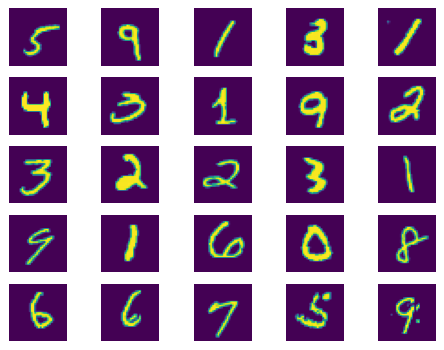

['5', '9', '1', '3', '1', '4', '3', '1', '9', '2', '3', '2', '2', '3', '1', '9', '1', '6', '0', '8', '6', '6', '7', '5', '9']


In [4]:
# get dataset
from torchvision.datasets import MNIST
from torchvision import transforms

transform = transforms.Compose([transforms.ToTensor(), transforms.Pad(2)])
mnist = MNIST("data", download=True, transform=transform)
display_dataset(mnist)

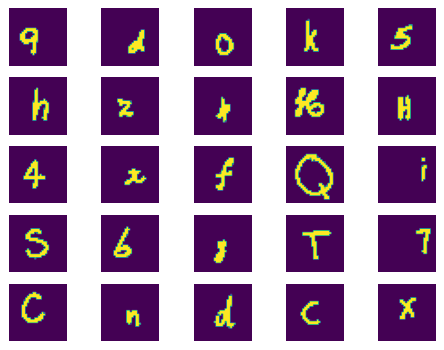

['q', 'd', 'o', 'k', '5', 'h', 'z', 'p', 'H', 'H', '4', 'x', 'f', 'Q', 'i', 's', 'b', 'y', 'T', '7', 'C', 'n', 'd', 'c', 'X']


In [30]:


class EnglishDataset(VisionDataset):
    def __init__(
        self,
        root: str,
        transforms: Optional[Callable] = None,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None) -> None:
        super().__init__(root, transforms, transform, target_transform)

        self.dataset = pd.read_csv(f"{root}/english.csv")
        self.images = [None for i in range(len(self))]
        self.labels = [None for i in range(len(self))]

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        if self.images[index] is None:
            self.load(index)
        return self.images[index], self.labels[index]

    def load(self, index):
        filename = f"{self.root}/{self.dataset['image'][index]}"
        image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE).astype(np.float32)
        image = cv2.resize(image, (42, 32))
        
        # crop based on center of the drawing
        nonzeros = np.nonzero(np.sum(image, axis=0) < 28 * 255)[0]
        # restrict center so that both ends are within the actual image
        center = min(max(nonzeros[0] + nonzeros[-1] // 2, 16), 37 - 16)
        transformed_image = 1 - image[:, center-16:center+16] / 255

        label = ord(self.dataset['label'][index])
        if label <= ord('9'): # 0 to 9
            label -= ord('0') # 48
        elif label <= ord('Z'): # A to Z
            label -= ord('A') - 10
        elif label <= ord('z'): # a to z
            label -= ord('a') - 36

        self.images[index] = np.expand_dims(transformed_image, axis=0)
        self.labels[index] = label

    def load_all(self):
        self.data = []

        for i in range(len(self.dataset)):
            filename = f"{self.root}/{self.dataset['image'][i]}"
            image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE).astype(np.float32)
            image = cv2.resize(image, (37, 28))
            
            # crop based on center of the drawing
            nonzeros = np.nonzero(np.sum(image, axis=0) < 28 * 255)[0]
            # restrict center so that both ends are within the actual image
            center = min(max(nonzeros[0] + nonzeros[-1] // 2, 14), 37 - 14)
            transformed_image = 1 - image[:, center-14:center+14] / 255

            label = ord(self.dataset['label'][i])
            if label <= ord('9'): # 0 to 9
                label -= ord('0') # 48
            elif label <= ord('Z'): # A to Z
                label -= ord('A') - 10
            elif label <= ord('z'): # a to z
                label -= ord('a') - 36

            # print(self.dataset['label'][i], label)

            self.data.append((np.expand_dims(transformed_image, axis=0), label))

    def __len__(self):
        return len(self.dataset)

english = EnglishDataset("data")
display_dataset(english)

In [6]:

class AZHandWritten(VisionDataset):
    def __init__(
        self,
        root: str,
        transforms: Optional[Callable] = None,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None) -> None:
        super().__init__(root, transforms, transform, target_transform)

        dataset = pd.read_csv(f"{root}/A_Z Handwritten Data.csv")
        dataset.rename(columns={'0':'label'}, inplace=True)

        # Splite data the X - Our data , and y - the prdict label
        self.features = dataset.drop('label',axis = 1)
        self.labels = dataset['label']
    
    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        features = self.features.iloc[index].values
        features = features.reshape((1, 28, 28)).astype(np.float32) / 255
        return features, self.labels[index]

    def __len__(self):
        return len(self.labels)


# azhand = AZHandWritten("data")
# display_dataset(azhand)

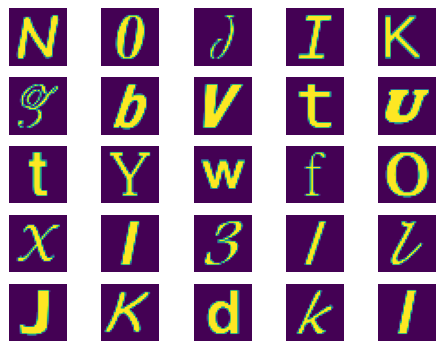

['N', '0', 'J', 'I', 'K', 'Z', 'b', 'V', 't', 'U', 't', 'Y', 'w', 'f', 'O', 'X', 'I', '3', 'I', 'l', 'J', 'K', 'd', 'k', 'l']


In [7]:

class EnglishFnt(VisionDataset):
    def __init__(
        self,
        root: str,
        split: str = 'train',
        transforms: Optional[Callable] = None,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None) -> None:
        super().__init__(root, transforms, transform, target_transform)

        match split:
            case 'train':
                self.count = 800
                self.start_index = 0
            case 'test':
                self.count = 216
                self.start_index = 800
            case 'full':
                self.count = 1016
                self.start_index = 0

        self.dataset = [[None for _ in range(self.count)] for _ in range(62)]
    
    def load(self, label, index):
        filename = f"{self.root}/English/Fnt/Sample{label+1:03}/img{label+1:03}-{index+1+self.start_index:05}.png"
        image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, (32, 32))
        image = 1 - np.expand_dims(image, 0).astype(np.float32) / 255
        self.dataset[label][index] = image
        return image
    
    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        # print(index, index // self.count, index % self.count)
        label = index // self.count
        index = index % self.count

        image = self.dataset[label][index]
        if image is None:
            image = self.load(label, index)
        return image, label

    def __len__(self):
        return 62 * self.count

english_fnt = EnglishFnt("data", split='full')
display_dataset(english_fnt, random=True)

# english_test = EnglishFnt("data", split='test')

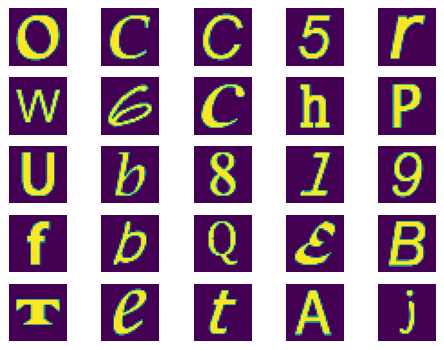

['o', 'C', 'C', '5', 'r', 'W', '6', 'c', 'h', 'P', 'U', 'b', '8', '1', '9', 'f', 'b', 'Q', 'E', 'B', 'T', 'e', 't', 'A', 'j']


In [8]:
from torch.utils.data import DataLoader
dataloader = DataLoader(english_fnt, batch_size=25, shuffle=True)
for data, target in dataloader:
    
    plt.figure(dpi=90)
    for i, img in enumerate(data):
        plt.subplot(5, 5, i+1)
        plt.imshow(img[0])
        plt.axis('off')
    plt.show()
    print([to_char(i) for i in target])
    break

In [23]:
detector = ScoreDetector().load("score_detector.pth")

In [35]:
from torch.utils.data import DataLoader
loss_fn = nn.CrossEntropyLoss()
num_epochs = 10
optimizer = torch.optim.Adam(detector.model.parameters(), lr=1e-5)

detector.to(device)

pbar = tqdm(range(num_epochs))
for e in pbar:
# for e in range(num_epochs):
    # Shuffle dataset in each epoch
    index = torch.randint(0, 3, (1,))
    dataset = [mnist, english_fnt, english][index.item()]
    dataloader = DataLoader(dataset, batch_size=1016, shuffle=True)
    # progress bar
    # pbar = tqdm(dataloader)
    # for data, target in pbar:
    for data, target in dataloader:
    #     data = torch.tensor(data).unsqueeze(0)
    #     target = torch.tensor(target).unsqueeze(0)
        # Obtain data from training split
        
        result = detector.model(data.to(device))
        # print(result)
        loss = loss_fn(result, target.to(device))
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Record loss values
        pbar.set_postfix(loss=loss.item())

100%|██████████| 10/10 [00:15<00:00,  1.54s/it, loss=0.0858]


In [32]:
english_test = EnglishFnt("data", 'test')
dataloader = DataLoader(english_test, batch_size=3000, shuffle=True)
detector.to(device)
correct = 0
total = len(english_test)
for data, target in dataloader:
    # Obtain data from training split
    result = detector.model(data.to(device))
    _, result = torch.max(result, dim=1)
    correct += torch.sum(result == target.to(device))
print(correct / total)

tensor(0.9372, device='cuda:0')


In [33]:
detector.save("score_detector.pth")

In [34]:
# accuracy
test_set = MNIST("data", train=False, download=True, transform=transforms.ToTensor())


dataloader = DataLoader(test_set, batch_size=1000)
detector.to(device)

correct = 0
total = len(test_set)

for data, target in dataloader:
    # Obtain data from training split
    padded = nn.ZeroPad2d(2)(data.to(device))
    logit = detector.model(padded)
    _, result = torch.max(logit, dim=1)
    correct += torch.sum(result == target.to(device))

print(correct.item() / total)

0.9374
